## Predicting Teacher Attrition Rates for Public Schools
**This notebook explores predicting teacher attrition rates for public schools in North Carolina.** 
* Public school data, county crime rate data and school income tax data are considered when making predictions in this notebook.
* The North Carolina Educational Attainment Data Repository for Machine Learning is located on Github at: https://github.com/wtubin/TeacherRetentionofNC

**For documentation on various Generalized Linear Models in Sklearn see:**
* http://scikit-learn.org/stable/modules/linear_model.html
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python

In [1]:
#!pip install xgboost
#!pip install pyshp
#!pip install ml_metrics 
# need c++ 1.04 http://go.microsoft.com/fwlink/?LinkId=691126&fixForIE=.exe.
#!pip install minepy 

In [2]:
#import required Libraries
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns; #sns.set()
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics as mt
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV    
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_validate

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from yellowbrick.features import JointPlotVisualizer
from scipy.stats import pearsonr
from sklearn.metrics import explained_variance_score
import xgboost




import warnings
#warnings.simplefilter('ignore')

%matplotlib inline


In [3]:

#ML2017 = '../2017/Machine Learning Datasets/PublicSchools2017_ML.csv'
# ML2016 = '../Machine Learning Datasets/PublicSchools2016_ML.csv'
# ML2015 =  '../2015/Machine Learning Datasets/PublicSchools2015_ML.csv'
ML2014 =  '../Machine Learning Datasets/PublicSchools2014_ML.csv'

# schData2017=pd.read_csv(ML2017, low_memory=False)
# print('*********************************2017 ML Data*************************************')
# schData2017.info()
# schData2016=pd.read_csv(ML2016, low_memory=False)
# print('*********************************2016 ML Data*************************************')
# schData2016.info()

# schData2015=pd.read_csv(ML2015, low_memory=False)
# print('*********************************2015 ML Data*************************************')
# schData2015.info()

schData2014=pd.read_csv(ML2014, low_memory=False)
print('*********************************2014 ML Data*************************************')
schData2014.info()

*********************************2014 ML Data*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2426 entries, 0 to 2425
Columns: 366 entries, closed_ind to unit_code
dtypes: float64(333), int64(33)
memory usage: 6.8 MB


## Fix Year

In [4]:
schData2014["Year"]=2014
# schData2015["Year"]=2015
# schData2016["Year"]=2016
# schData2017["Year"]=2017

In [5]:
# Combine the data sets
# schData = pd.concat([schData2017,schData2016,schData2015,schData2014], axis=0, ignore_index=True, sort = True)
schData = schData2014

## Remove missing data after merge

In [6]:
#Missing Data Threshold (Per Column)
missingThreshold = 0.60

#Unique Value Threshold (Per Column)
#Delete Columns >  uniqueThreshold unique values prior to one-hot encoding. 
#(each unique value becomes a new column during one-hot encoding)
uniqueThreshold = 25


#Eliminate continuous columns with more than missingThreshold percentage of missing values
schoolDataRecordCt = schData.shape[0]
missingValueLimit = schoolDataRecordCt * missingThreshold
NullValueCounts = schData.isnull().sum()
NullValueCols = NullValueCounts[NullValueCounts >= missingValueLimit].index
schData = schData.drop(NullValueCols, axis=1)

#Review dataset contents after empty field drops
print('*********After: Removing columns with >= missingThreshold % of missing values******')
schData.info(verbose=False)
print ('\r\nColumns Deleted: ', len(NullValueCols))


*********After: Removing columns with >= missingThreshold % of missing values******
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2426 entries, 0 to 2425
Columns: 366 entries, closed_ind to unit_code
dtypes: float64(332), int64(34)
memory usage: 6.8 MB

Columns Deleted:  0


In [7]:
#Replace all remaining NaN with 0
schData = schData.fillna(0)

#Check for Missing values after final imputation 
missing_values = schData.isnull().sum().reset_index()
missing_values.columns = ['Variable Name', 'Number Missing Values']
missing_values = missing_values[missing_values['Number Missing Values'] > 0] 
missing_values

,Variable Name,Number Missing Values


In [8]:
schData['_1yr_tchr_trnovr_pct'].describe()
# 'Number of farm returns All',
# 'Number of farm returns 100KLT200K'
# 'Number of farm returns LT25K',
# 'Number of farm returns 25KLT50K',
# 'Number of farm returns 50KLT75K',
# 'Number of farm returns 75KLT100K',
# 'Number of farm returns GE200K'

count    2426.000000
mean        0.140457
std         0.088298
min         0.000000
25%         0.082250
50%         0.128000
75%         0.183000
max         0.818000
Name: _1yr_tchr_trnovr_pct, dtype: float64

### we are not remove the 0 1 year percentage for now.

In [9]:
# https://ncreportcards.ondemand.sas.com/src/school?school=840344&year=2017&lang=english
# verified the 1 year teacher turn over rate from above website. it looks like these are 0
zeroAttrition = schData[schData['_1yr_tchr_trnovr_pct']==0.0].index

#schData = schData.drop(zeroAttrition,axis=0)
schData['_1yr_tchr_trnovr_pct'][schData['_1yr_tchr_trnovr_pct']==0.0] = 0.001

#print('*********After: Removing rows with first year turn over percentage =0.00******')
print('*********After: change turn over percentage =0.01******')
schData.info(verbose=False)
print ('\r\nRows Deleted: ', len(zeroAttrition))

*********After: change turn over percentage =0.01******
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2426 entries, 0 to 2425
Columns: 366 entries, closed_ind to unit_code
dtypes: float64(332), int64(34)
memory usage: 6.8 MB

Rows Deleted:  115


C:\Users\yubin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
 schData[schData['_1yr_tchr_trnovr_pct']==0.0]

,closed_ind,student_num,lea_avg_student_num,st_avg_student_num,Math I_Size,lea_total_expense_num,lea_salary_expense_pct,lea_benefits_expense_pct,lea_services_expense_pct,lea_supplies_expense_pct,...,Reading SPG Grade_D,Reading SPG Grade_F,Math SPG Grade_B,Math SPG Grade_C,Math SPG Grade_D,Math SPG Grade_F,EVAAS Growth Status_Met,EVAAS Growth Status_NotMet,esea_attendance_Met,unit_code


## Visulization

### Heat map

#### 1 Year Teacher Turnover

<img src="North Carolina 2017 One Year Teacher Attrition Rate by zip code.png"></img>

#### Crime Index Rate

<img src="North Carolina 2017 Crame Index Rate by zip code.png"></img>

### Histogram

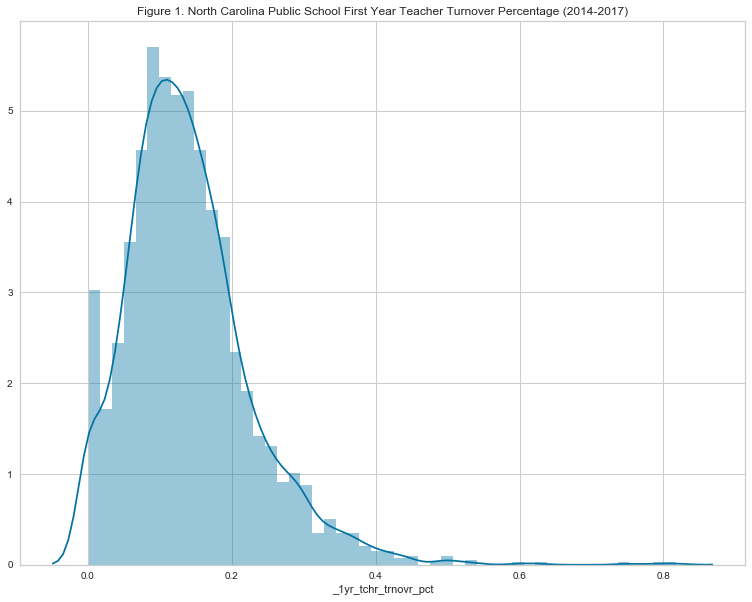

In [11]:
plt.figure(figsize=(13,10))
_1yr_tchr_trnovr_pct = schData["_1yr_tchr_trnovr_pct"]
ax = sns.distplot(_1yr_tchr_trnovr_pct);
plt.title("Figure 1. North Carolina Public School First Year Teacher Turnover Percentage (2014-2017)")
plt.show()

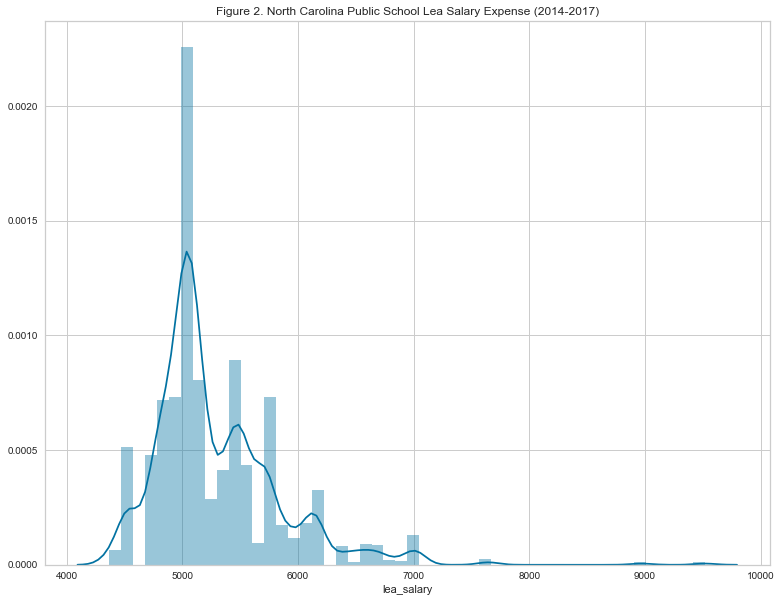

In [12]:
schData['lea_salary'] = schData['lea_total_expense_num']*schData['lea_salary_expense_pct']

plt.figure(figsize=(13,10))
lea_salary_expense_pct=schData.lea_salary_expense_pct
ax = sns.distplot(schData['lea_salary']);
plt.title("Figure 2. North Carolina Public School Lea Salary Expense (2014-2017)")
plt.show()

In [13]:
# responseible variabl distribution
schData['_1yr_tchr_trnovr_pct'].describe()

count    2426.000000
mean        0.140504
std         0.088223
min         0.001000
25%         0.082250
50%         0.128000
75%         0.183000
max         0.818000
Name: _1yr_tchr_trnovr_pct, dtype: float64

## we may want to check the outliers

In [14]:
#Create a function to plot regression lines for two variables
def PlotJoint(x,y,data):
    sns.set(context='notebook', style='darkgrid', font_scale=1.25)
    my_plot = sns.jointplot(x=x, y=y, data=data, kind="reg");
    my_plot.fig.set_figwidth(8)
    my_plot.fig.set_figheight(8)

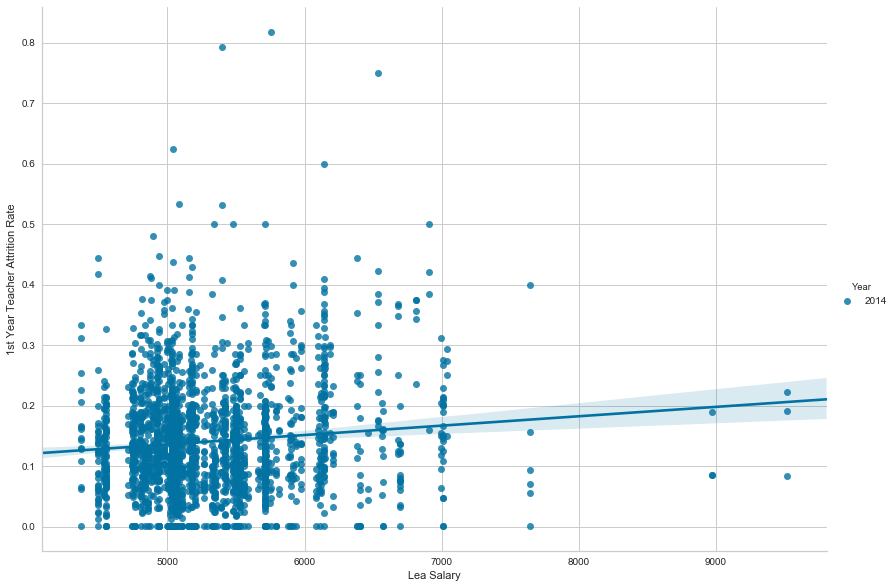

In [15]:
# #sns.set_style("darkgrid")
data = schData
sns.lmplot(x="lea_salary", y="_1yr_tchr_trnovr_pct", hue = "Year",  data=data,height=8.27, aspect=11.7/8.27)
sns.despine()

#plt.title("Figure 3. North Carolina Public School One Year Teacher Attrition Rate vs. LEA Salary Expenditure (2014-2017)")
plt.ylabel('1st Year Teacher Attrition Rate')
plt.xlabel('Lea Salary')
#plt.show()
plt.savefig('Figure1.png')

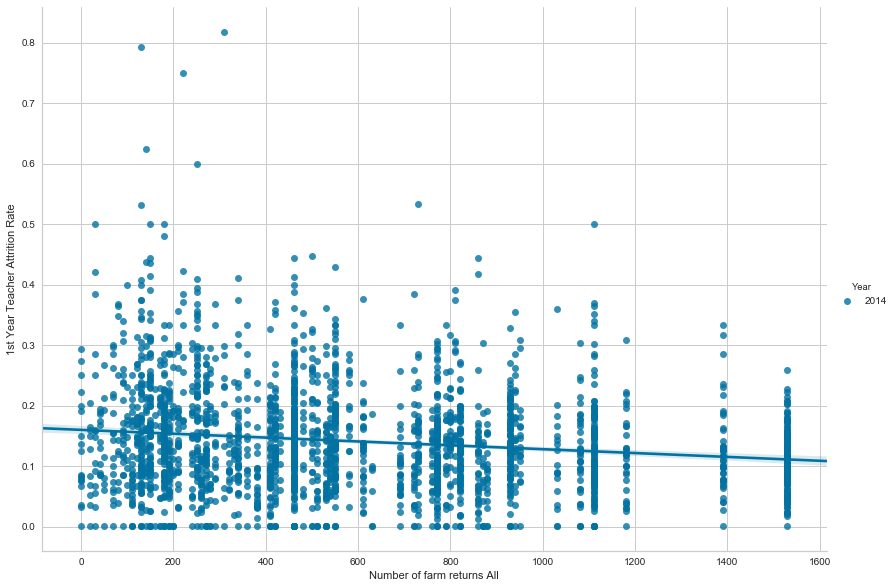

In [16]:
# #sns.set_style("darkgrid")
data = schData
sns.lmplot(x="Number of farm returns All", y="_1yr_tchr_trnovr_pct", hue="Year",  data=data,height=8.27, aspect=11.7/8.27)
sns.despine()

#plt.title("Figure 3. North Carolina Public School One Year Teacher Attrition Rate vs. LEA Salary Expenditure (2014-2017)")
plt.ylabel('1st Year Teacher Attrition Rate')
plt.xlabel('Number of farm returns All')
#plt.show()
plt.savefig('Figure1.png')


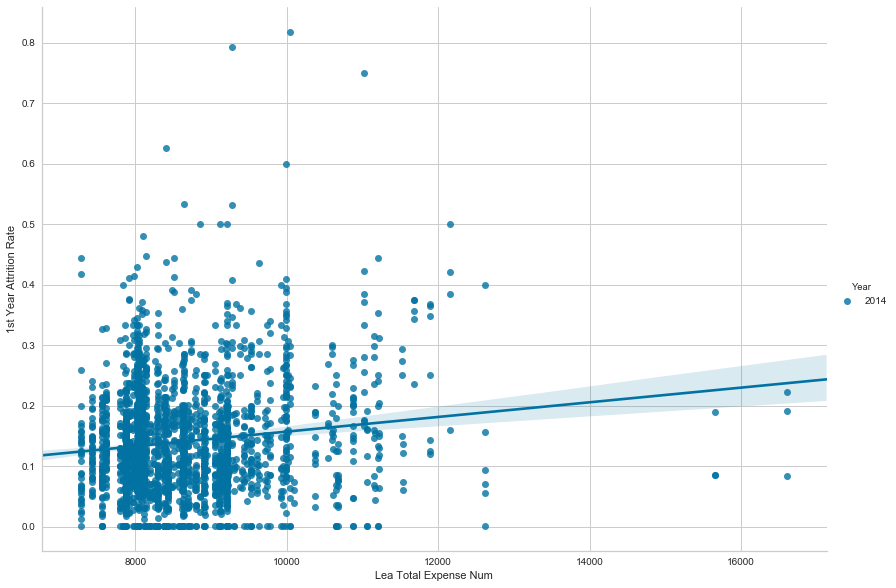

In [17]:
sns.lmplot(x="lea_total_expense_num", y="_1yr_tchr_trnovr_pct", hue="Year", data=schData,height=8.27, aspect=11.7/8.27)
sns.despine()

#plt.title("Figure 4. North Coralina Public School One Year Teacher Attrition Rate vs. LEA Total School Expenditure (2014-2017)")
plt.ylabel('1st Year Attrition Rate')
plt.xlabel('Lea Total Expense Num')
plt.savefig('Figure2.png')

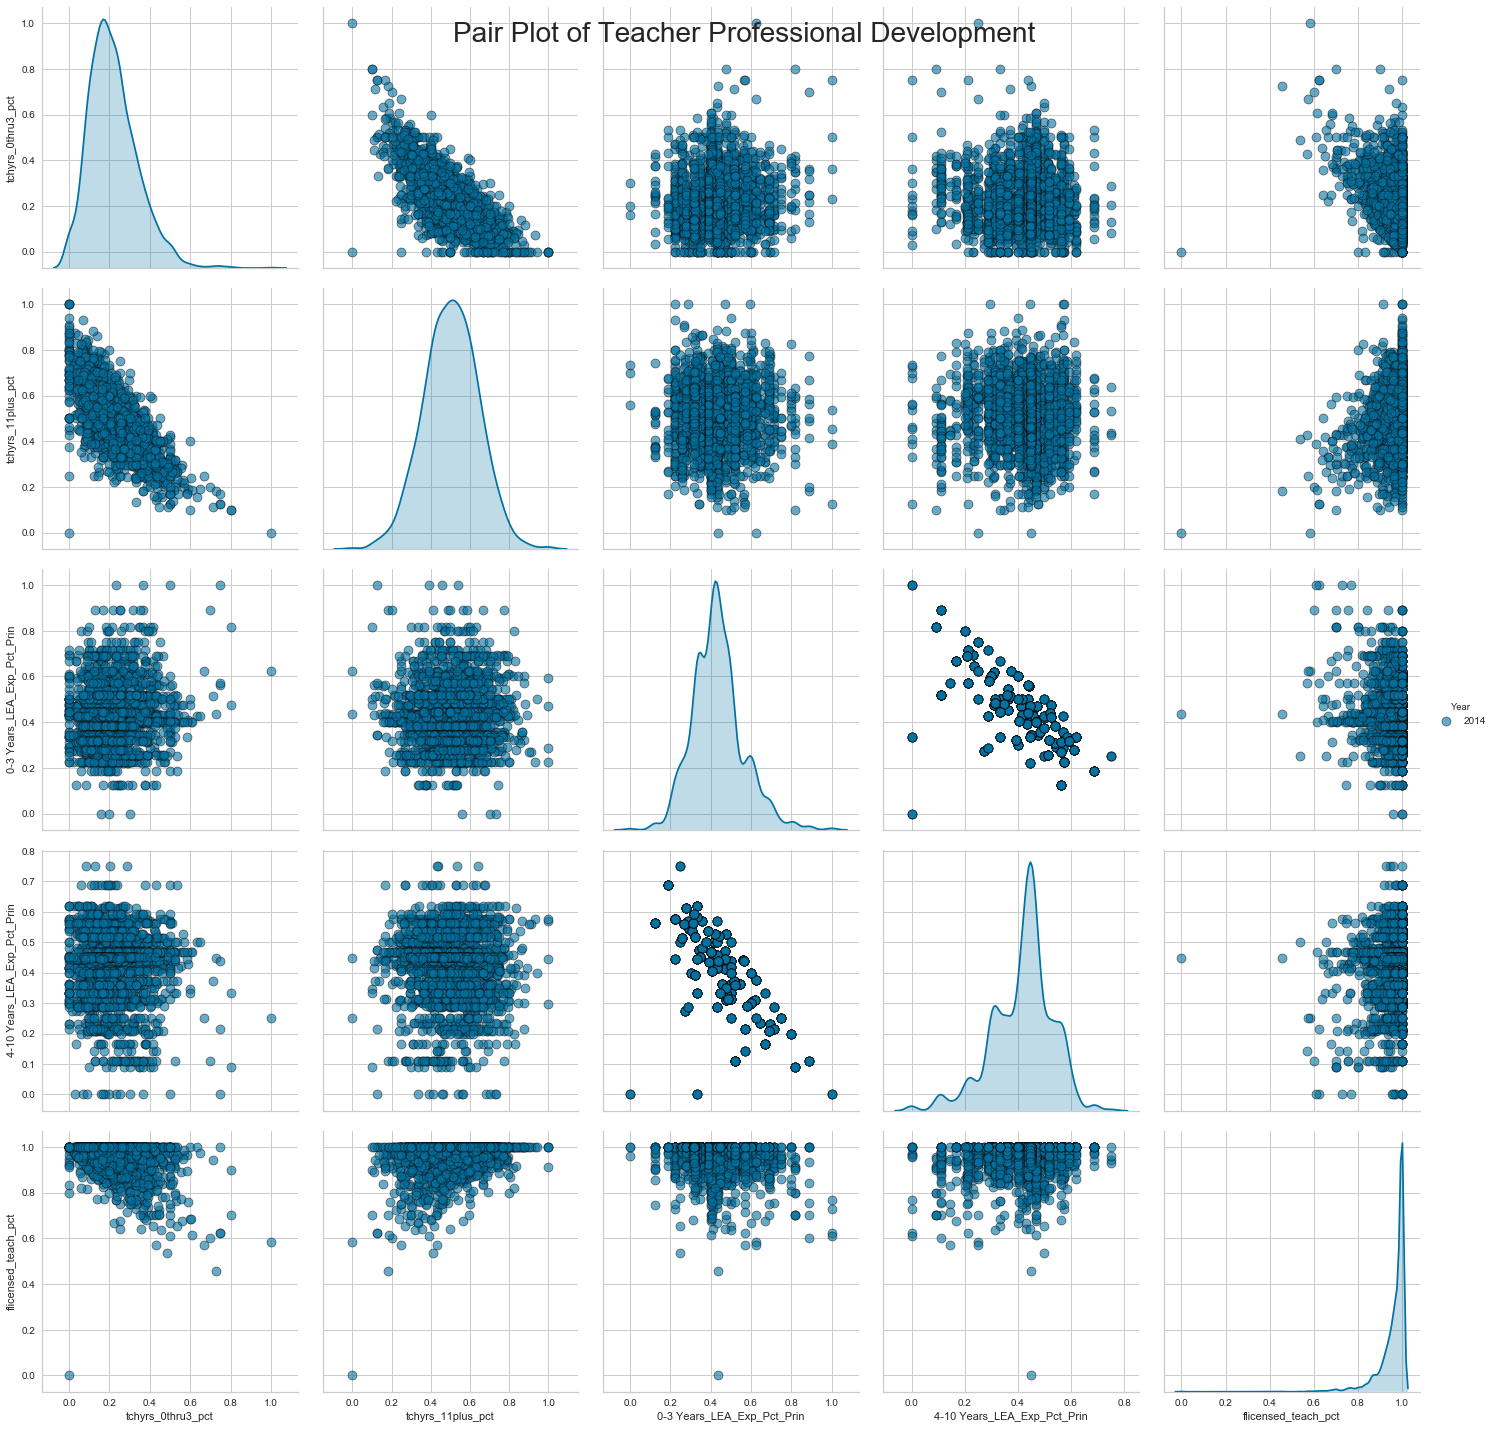

In [18]:
# pair plot
teacherProf = schData[['tchyrs_0thru3_pct','tchyrs_11plus_pct','0-3 Years_LEA_Exp_Pct_Prin','4-10 Years_LEA_Exp_Pct_Prin','flicensed_teach_pct','Year']]
sns.pairplot(teacherProf
             ,vars = ['tchyrs_0thru3_pct','tchyrs_11plus_pct','0-3 Years_LEA_Exp_Pct_Prin','4-10 Years_LEA_Exp_Pct_Prin','flicensed_teach_pct']
             , hue = 'Year', diag_kind = 'kde', plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},height = 4)
# Title 
plt.suptitle('Pair Plot of Teacher Professional Development', 
             size = 28);

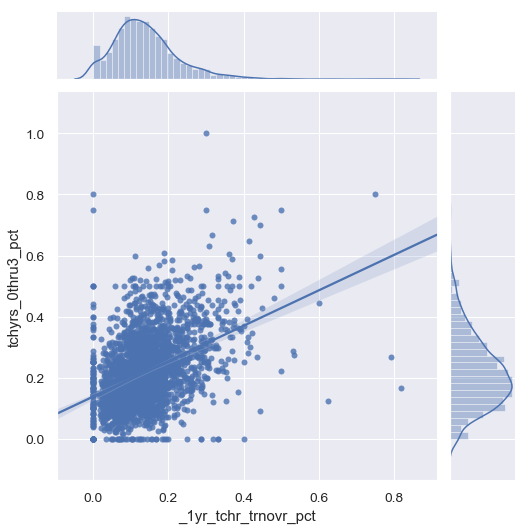

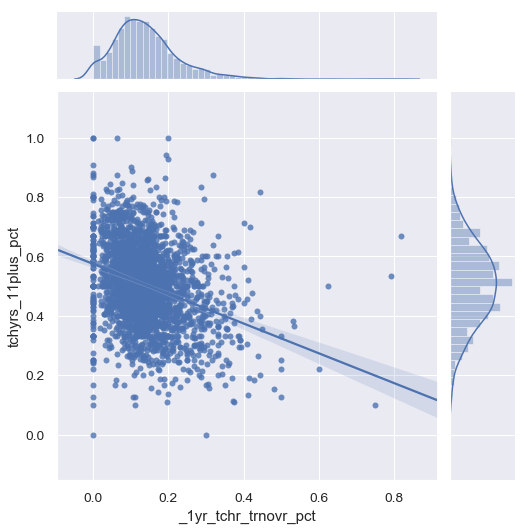

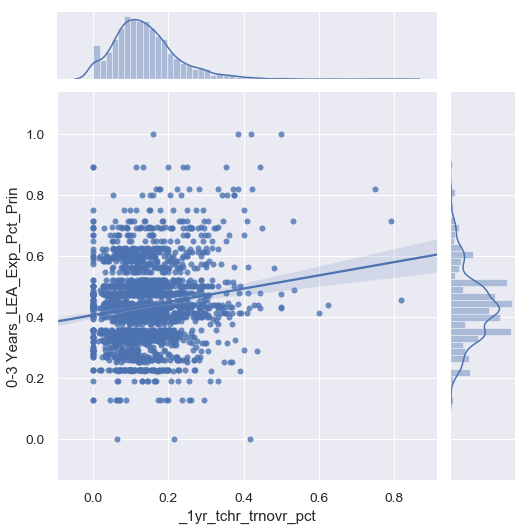

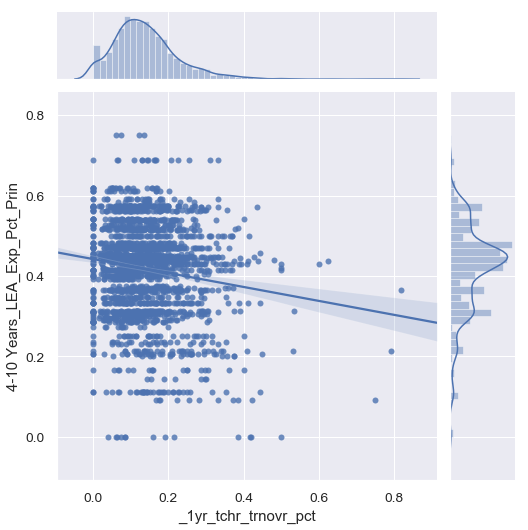

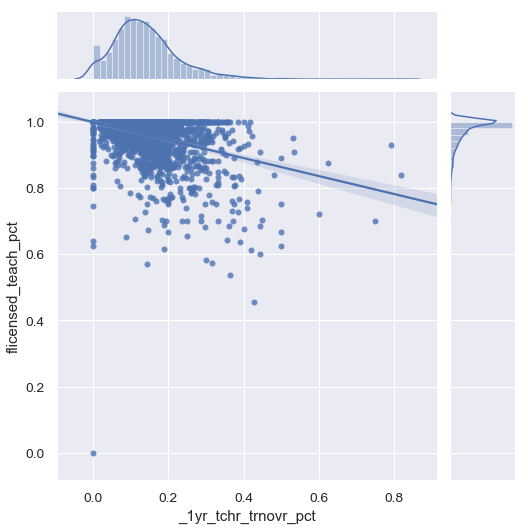

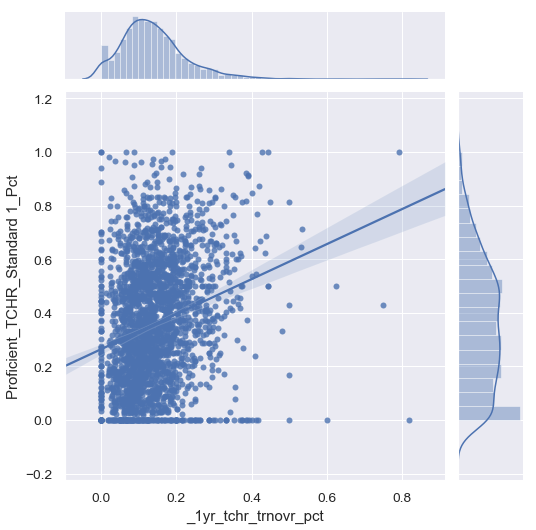

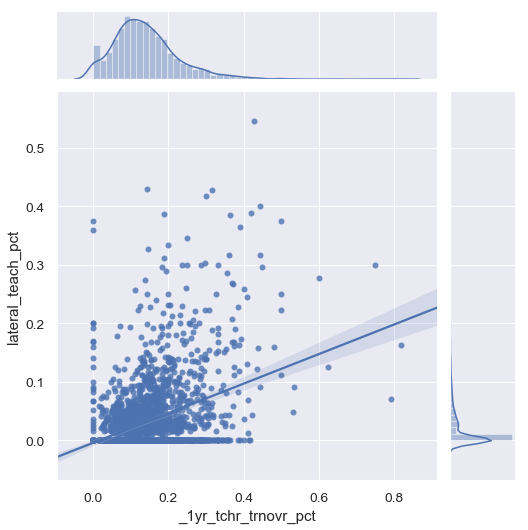

In [19]:
#Create district level charts to compare against Avg Tot Income
teachprof = ['tchyrs_0thru3_pct','tchyrs_11plus_pct','0-3 Years_LEA_Exp_Pct_Prin','4-10 Years_LEA_Exp_Pct_Prin'
             ,'flicensed_teach_pct','Proficient_TCHR_Standard 1_Pct','lateral_teach_pct'
            
            ]

for col in teachprof:
    #print(col)
    try:
        PlotJoint(x='_1yr_tchr_trnovr_pct',y=col, data=schData)
    except Exception:
        print("Error")
        continue

In [ ]:
sns.pairplot(schData, x_vars=['Crime_Rate_Index_Rate','Crime_Rate_Arson_Rate','crime_per_c_num']
             , y_vars='_1yr_tchr_trnovr_pct', size=7, aspect=0.7, kind='reg')

C:\Users\yubin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


In [ ]:
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="Year", y="_1yr_tchr_trnovr_pct", data=schData)
ax = sns.swarmplot(x="Year", y="_1yr_tchr_trnovr_pct", data=schData, color=".25")
plt.ylabel('1st Year Teacher Attrition Rate')
plt.xlabel('Year')
plt.savefig('Figure3.png')

In [ ]:
schData.head()

## Feature Selection
* set max features we want to select

### Manually remove columns

* there columns is not what we are interested in, so we remove them manaually from data set

In [ ]:
# manually remove the columns

ManualDropFeatures = ['st_1yr_tchr_trnovr_pct','lea_1yr_tchr_trnovr_pct'
                     ,'PacificIslandPct','PacificIslandMalePct','PacificIslandFemalePct','HispanicPct'
                      ,'BlackPct','AsianPct','IndianPct','WhitePct','TwoOrMorePct','TwoOrMoreMalePct','TwoOrMoreFemalePct'

#                       ,'lea_supplies_expense_pct'
#                       ,'lea_services_expense_pct','lea_salary_expense_pct'
                      
                      
                      ,'lea_total_expense_num'
                      #,'lea_benefits_expense_pct'
                      ,'lea_state_perpupil_num'
                      ,'lea_local_perpupil_num'
                      ,'lea_federal_perpupil_num'
                      
                      ,'st_avg_student_num'
#                      ,'st_expelled_per_c_num'
                     ,'st_crime_per_c_num'
#                      ,'st_avg_daily_attend_pct'
#                        ,'st_tchyrs_11plus_pct'
                     ,'st_emer_prov_teach_pct'
#                      ,'st_long_susp_per_c_num'
                     ,'st_flicensed_teach_pct'
#                      ,'st_short_susp_per_c_num'


                     ]

schData = schData.drop(ManualDropFeatures,axis=1)
print('*********After: Removing fetures we are not interested in ******')
schData.info(verbose=False)
print ('\r\nFeatures Deleted: ', len(ManualDropFeatures))

## These features have big number of the weight in feature selection, trying to remove them and see if it will be better

In [ ]:
# schData = schData.drop(['Number of farm returns All','Number of farm returns 100KLT200K',
# 'Number of farm returns LT25K',
# 'Number of farm returns 25KLT50K',
# 'Number of farm returns 50KLT75K',
# 'Number of farm returns 75KLT100K',
# 'Number of farm returns GE200K'],axis=1)

In [ ]:
# backup the data set
schData_bak = schData
schData.info()

## random shuffle the data

In [ ]:
from sklearn.utils import shuffle
schData = shuffle(schData)

In [ ]:
schData.head()

In [ ]:
# Get the X and y
y= schData['_1yr_tchr_trnovr_pct']
X = schData.drop(['_1yr_tchr_trnovr_pct'],axis=1)
# save the header
saved_cols = X.columns

## Transformation

In [ ]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# #Save as data frames
# X = pd.DataFrame(X)
# X.columns = saved_cols


####  Normalizing the Data
* standardize data so that variance is 1 and mean is zero.

In [ ]:
# credit: https://fatihsarigoz.com/scaling-rfe.html
# Transform


scaler = StandardScaler()
X_Stanardized = scaler.fit_transform(X)
#Save as data frames
X_Stanardized = pd.DataFrame(X_Stanardized)
X_Stanardized.columns = saved_cols

* rescale range to (0,1)

In [ ]:
# # Rescale data (between 0 and 1)
# from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_reScaled =pd.DataFrame( scaler.fit_transform(X))
X_reScaled = pd.DataFrame(X_reScaled)
X_reScaled.columns = saved_cols

## Features Selection

In [ ]:
# threthold for the feature selection
max_features =200

#schData = schData_bak

In [ ]:
# Credit https://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/
# https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models


from sklearn.linear_model import (LinearRegression, Ridge, Lasso,ElasticNet)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from minepy import MINE

np.random.seed(0)
size = 750
names = X.columns
ranks = {}
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

lr = LinearRegression(normalize=True)
lr.fit(X_Stanardized, y)
#ranks["Linear reg"] = rank_to_dict(np.abs(lr.coef_), names)
ranks["Linear reg"] = rank_to_dict(lr.coef_, names)

ridge = Ridge(alpha=7)
ridge.fit(X_Stanardized, y)
#ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)
ranks["Ridge"] = rank_to_dict(ridge.coef_, names)

lasso = Lasso(alpha=.0001)
lasso.fit(X_reScaled, y)
#ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)
ranks["Lasso"] = rank_to_dict(lasso.coef_, names)

elasticNet = ElasticNet(alpha=.0001)
elasticNet.fit(X_reScaled, y)
#ranks["ElasticNet"] = rank_to_dict(np.abs(ElasticNet.coef_), names)
ranks["ElasticNet"] = rank_to_dict(elasticNet.coef_, names)


# rlasso = RandomizedLasso(alpha=0.04)
# rlasso.fit(X, Y)
# ranks["Stability"] = rank_to_dict(np.abs(rlasso.scores_), names)

#stop the search when 5 features are left (they will get equal scores)
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X_Stanardized,y)
ranks["RFE"] = rank_to_dict(list(map(float, rfe.ranking_)), names, order=-1)

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_Stanardized,y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)


f, pval = f_regression(X_Stanardized, y, center=True)
ranks["Corr."] = rank_to_dict(f, names)


mine = MINE(alpha=.05)
mic_scores = []
for i in range(X_Stanardized.shape[1]):
    #print(i)
    mine.compute_score(np.array(X_Stanardized)[:,i], y)
    m = mine.mic()
    mic_scores.append(m)
ranks["MIC"] = rank_to_dict(mic_scores, names) 
#print(ranks["MIC"])

r = {}
for name in names:
    r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

# print ("\t%s" % "\t".join(methods))
# for name in names:
#     print("%s\t%s" % (name, "\t".join(map(str,[ranks[method][name] for method in methods]))))
ranksDF = pd.DataFrame(ranks)
ranksDF.sort_values(by='Mean', inplace=True, ascending=False )
#ranksDF.columns = ['feature_names','Linear reg','Ridge','Lasso','ElasticNet','RFE','RF','Corr.','MIC','Mean']

ranksDF.to_csv("RFE_Feature_Importance_Results_2017.csv")

In [ ]:
ranksDF.head(20)

In [ ]:
ranksDF['Mean'].describe()

In [ ]:
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
meanplotTop50 = meanplot[0:50]
# Let's plot the ranking of the features
sns.catplot(x="Mean Ranking", y="Feature", data = meanplotTop50, kind="bar", 
               height=20, aspect=1.9, palette='coolwarm')

In [ ]:
# feature_to_remove = ranksDF[ranksDF['Mean']<=.28].index
# X = X.drop(feature_to_remove, axis=1)

# #feature_to_remove
# print ('\r\nFeatures Deleted: ', len(feature_to_remove))

In [ ]:
feature_to_remove = ranksDF[ranksDF['Mean']<=ranksDF['Mean'].mean()-ranksDF['Mean'].std()].index
X_Stanardized = X_Stanardized.drop(feature_to_remove, axis=1)

#feature_to_remove
print ('\r\nFeatures Deleted: ', len(feature_to_remove))

In [ ]:
feature_to_remove

In [ ]:
X_Stanardized.info()

## Cross Validation
**Cross validation is performed using repeated holdout using ShuffleSplit()**
* Ten folds are used
* The split is: 90% training data and 10% test data
* A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [ ]:
#Divide data into test and training splits
#from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=12)

X_train, X_test, y_train, y_test = train_test_split(X_Stanardized, y, test_size=0.1,random_state =12 )
print("Training set", X_train.shape, y_train.shape)
print("Test set", X_test.shape, y_test.shape)


## Custom Scorers for Evaluating Regression Models 

**All regression models created in this notebook are validated using the following metrics:**
* Mean Absolute Error (MAE)
* Root Mean Squared Error (RMSE) - https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
* Mean Absolute Percentage Error (MAPE) - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python

**For details on making scorers to return multiple mean error scores see:**
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
* https://github.com/scikit-learn/scikit-learn/pull/7388
* https://github.com/drorata/multiscorer

In [ ]:
# it may not make sense to use MAPE in our project based on below articles:
# http://www.catchbull.com/catchblogs/why-mape-doesnt-work


## Regression Model Evaluation
** All regression models are evaluated using the regression model evaluation function below: ** 
* The following regression evaluation function uses the cross validation object and the custom scorers in the two cells above in combination with sklearn.model_selection's cross_validate function to perform cross validation for regression estimators.
* The cross validation object above uses a random seed to ensure that all regression estimators are tested on the same randomly selected records for each cross validation fold.
* Custom scorers are created using the three chosen mean error scores and passed into cross_validate(), so all three scores are calcualted using a single call to cross_validate().
* All of this functionality is wrapped within the custom EvaluateRegressionEstimator() function below so multiple regression models may be tested using the same test / train cv data and evaluation scores producing a consistent output for each model without the need to re-write the same code over and over. 

In [ ]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score 
from ml_metrics import rmse

#from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_scorer 

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
# def rmse(y_actual, y_predicted):
#     return np.sqrt(mean_squared_error(y_actual, y_predicted))




#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
# revised from - https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
# still not working
def mape(y_actual, y_predicted): 
    mask = y_actual != 0 
    #print(y_actual)
#     print(y_predicted)
#     return (np.abs(y_actual - y_predicted)/y_actual)[mask].mean() * 100
    y_actual, y_pred = np.array(y_actual), np.array(y_predicted)
    return np.mean(np.abs((y_actual - y_pred) / y_actual))/len(y_actual) * 100
    
#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(score_func=mean_squared_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)
r2_scorer = make_scorer(score_func=r2_score, greater_is_better=True) 

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'MSE':  mse_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer,
                'R2': r2_scorer       
               } 

In [ ]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #print(scores)
    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MSE'] = scores['test_MSE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

     #print mean MAE for all folds 
    mseAvg = scores['test_MSE'].mean()
    print_str = "The average MSE for all cv folds is: \t\t\t {mseAvg:.5}"
    print(print_str.format(mseAvg=mseAvg))
    
    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')
    
    #print mean R-squared for all folds 
    R2avg = scores['test_R2'].mean()
    print_str = "The average R-Squared for all cv folds is: \t\t {R2avg:.5}"
    print(print_str.format(R2avg=R2avg))
    print('*********************************************************')


    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MSE'] = scores['test_MSE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    scoresResults['R2'] = scores['test_R2']
    return scoresResults


## Baseline Regression Model

**Linear Regression is used to create a baseline model.  Since linear regression may predict response variable values outside the range of the training data's response variable, we create a linear regression estimator with graduation rate predictions clipped 0% and 100%. For details see:**
* http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator 
* https://github.com/scikit-learn/scikit-learn/issues/6950
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/template.py
* https://stackoverflow.com/questions/44234682/how-to-use-sklearn-when-target-variable-is-a-proportion

In [ ]:
#Make new estimator compatible for use with GridSearchCV() and cross_validate()
# -  Cap predict function for LinearRegression between 0 and 100
# -  See: Roll your own estimator links above for details. 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class CappedLinearRegression(LinearRegression):
    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 0, 100) 

### Linear Regression Grid Search
** Here we perform a grid search testing 40 models to find the best parameters for our Linear Regression model based on Mean Absolute Error.  See more on parameter tuning with grid search here:**
* http://scikit-learn.org/stable/modules/grid_search.html

In [ ]:
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = LinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False),'normalize': (True, False),}

#Create a grid search object using the  
linregGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#linregGridSearch hyperparameter search to find the best combination of parameters for our data
linregGridSearch.fit(X_Stanardized, y)

In [ ]:
#Print the parameterization of the best estimator
linregEstimator = linregGridSearch.best_estimator_
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
CappedLinear_Results = EvaluateRegressionEstimator(linregEstimator, X_Stanardized, y, cv)

In [ ]:
linregEstimator = linregGridSearch.best_estimator_

linregEstimator.fit(X_train, y_train)
linregyhat = linregEstimator.predict(X_test)
print("Yhat Max: ", linregyhat.max())
print(explained_variance_score(y_test,linregyhat, multioutput='uniform_average'))

In [ ]:
linCompare = pd.DataFrame([np.array(linregyhat),np.array(y_test)]).T
linCompare.columns=['linregyhat','y_test']

In [ ]:
sns.lmplot(x="linregyhat", y="y_test",  data=linCompare,height=8.27, aspect=11.7/8.27)
sns.despine()

#plt.title("Figure 4. North Coralina Public School One Year Teacher Attrition Rate vs. LEA Total School Expenditure (2014-2017)")
plt.ylabel('y_test')
plt.xlabel('linregyhat')
plt.savefig('Figure2.png')

## Support Vector Regression
**This model uses Support Vector Machines for regression of continuous variables (SVR). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
* http://scikit-learn.org/stable/modules/svm.html

In [ ]:
#Create a Linear regression object and perform a grid search to find the best parameters
from sklearn.svm import SVR
svr = SVR()

#Set up SVR parameters to test (WARNING: Creates 320 models!!!) 
costs = [0.001, 0.1]
defGamma = 1 / X.shape[1]  #This is the default value for the gamma parameter
gammas = [defGamma, 0.1]
kernels = [ 'linear', 'rbf']
parameters = {'C': costs, 'gamma' : gammas, 'kernel': kernels}

#Create a grid search object using the parameters above
#from sklearn.model_selection import GridSearchCV
svrGridSearch = GridSearchCV(estimator=svr
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
svrGridSearch.fit(X_Stanardized, y)

In [ ]:
#Display the best estimator parameters
svrGridSearch.best_estimator_

In [ ]:
# from sklearn.svm import SVR

#Create a regression estimator with best parameters for cross validation
# regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
#                    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svrEstimator = svrGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
SVR_Results=EvaluateRegressionEstimator(svrEstimator, X_Stanardized, y, cv)

In [ ]:
#Do we predict graduation rates greater than 100%?
# regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
#                    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svrEstimator.fit(X_train, y_train)
svr_yhat = svrEstimator.predict(X_test)
print("Yhat Max: ", svr_yhat.max())
print(explained_variance_score(y_test,svr_yhat, multioutput='uniform_average'))

In [ ]:
linCompare = pd.DataFrame([np.array(svr_yhat),np.array(y_test)]).T
linCompare.columns=['svr_yhat','y_test']

sns.lmplot(x="svr_yhat", y="y_test",  data=linCompare,height=8.27, aspect=11.7/8.27)
sns.despine()

#plt.title("Figure 4. North Coralina Public School One Year Teacher Attrition Rate vs. LEA Total School Expenditure (2014-2017)")
plt.ylabel('y_test')
plt.xlabel('svr_yhat')
plt.savefig('Figure2.png')

## Teacher Attrition Rate - Lasso Regression
**This model uses Lasso regression (L1 Norm). Please see documentation here:"**
* **Caution!** - See documentation for fit_intercept, normalize, and copy_X. Lasso can over-write your X data!
* Lasso may also perform scaling as well.  Please see docs!
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [ ]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso

lasso = Lasso()

#Test parameters 
alpha = [0.0001,0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
fit_intercept = [True, False]
normalize = [True, False]
copy_X = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start
              ,'fit_intercept':fit_intercept,'normalize':normalize,'copy_X': copy_X}

#Create a grid search object using the parameters above
lassoGridSearch = GridSearchCV(estimator=lasso
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
lassoGridSearch.fit(X_Stanardized, y)

In [ ]:
#Display the best estimator parameters
lassoGridSearch.best_estimator_

In [ ]:
#Create a regression estimator with best parameters for cross validation
lassoEstimator =lassoGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
Lasso_Results = EvaluateRegressionEstimator(lassoEstimator, X_Stanardized, y, cv)

In [ ]:
#Do we predict graduation rates greater than 100%?
# regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
#    normalize=True, positive=False, precompute=True, random_state=0,
#    selection='cyclic', tol=0.0001, warm_start=True)
#lassoEstimator = lassoGridSearch.best_estimator_

lassoEstimator.fit(X_train, y_train)
Lasso_yhat = lassoEstimator.predict(X_test)
print("Yhat Max: ", Lasso_yhat.max())
print(explained_variance_score(y_test,Lasso_yhat, multioutput='uniform_average'))

## Ridge Regression
**This model uses Ridge regression (L2 Norm). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [ ]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

ridge = Ridge()

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg']#, 'sag']#, 'saga']
parameters = {'alpha': alpha, 'solver': solver}
#parameters = {'alpha': alpha}

#Create a grid search object using the parameters above
#from sklearn.model_selection import GridSearchCV
ridgeGridSearch = GridSearchCV(estimator=ridge
                   , n_jobs=10 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
ridgeGridSearch.fit(X_Stanardized, y)

In [ ]:
#Display the best estimator parameters
ridgeGridSearch.best_estimator_

In [ ]:
%%time
#Create a regression estimator with best parameters for cross validation
ridgeEstimator = ridgeGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
Ridge_Results = EvaluateRegressionEstimator(ridgeEstimator, X_Stanardized, y, cv)

In [ ]:
#Do we predict graduation rates greater than 100%?
# regEstimator = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
#    normalize=True, random_state=0, solver='saga', tol=0.0001)
ridgeEstimator = ridgeGridSearch.best_estimator_

ridgeEstimator.fit(X_train, y_train)
ridge_yhat = ridgeEstimator.predict(X_test)
print("Yhat Max: ", ridge_yhat.max())
print(explained_variance_score(y_test,ridge_yhat))

In [ ]:
linCompare = pd.DataFrame([np.array(ridge_yhat),np.array(y_test)]).T
linCompare.columns=['ridge_yhat','y_test']

sns.lmplot(x="ridge_yhat", y="y_test",  data=linCompare,height=8.27, aspect=11.7/8.27)
sns.despine()

#plt.title("Figure 4. North Coralina Public School One Year Teacher Attrition Rate vs. LEA Total School Expenditure (2014-2017)")
plt.ylabel('y_test')
plt.xlabel('ridge_yhat')
plt.savefig('Figure2.png')

## Elastic Net Regression
**This model uses Elastic Net Regression (L1 and L2 Norm mixing). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [ ]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import ElasticNet

elasticNet = ElasticNet(fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)
 
#Test parameters
l1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
alpha = [0.001, 0.1, 1, 10]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'l1_ratio': l1_ratio, 'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
elasticNetGridSearch = GridSearchCV(estimator=elasticNet
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
elasticNetGridSearch.fit(X_Stanardized, y)

In [ ]:
#Display the best estimator parameters
elasticNetGridSearch.best_estimator_

In [ ]:
#Create a regression estimator with best parameters for cross validation
elasticNetEstimator = elasticNetGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
elastic_Results = EvaluateRegressionEstimator(elasticNetEstimator, X_Stanardized, y, cv)

In [ ]:
#Do we predict graduation rates greater than 100%?
elasticNetEstimator =  elasticNetGridSearch.best_estimator_

elasticNet = elasticNetEstimator.fit(X_train, y_train)
elasticNet_yhat = elasticNetEstimator.predict(X_test)
print("Yhat Max: ", elasticNet_yhat.max())
print(explained_variance_score(y_test,elasticNet_yhat, multioutput='uniform_average'))

In [ ]:
linCompare = pd.DataFrame([np.array(elasticNet_yhat),np.array(y_test)]).T
linCompare.columns=['elasticNet_yhat','y_test']

sns.lmplot(x="elasticNet_yhat", y="y_test",  data=linCompare,height=8.27, aspect=11.7/8.27)
sns.despine()

#plt.title("Figure 4. North Coralina Public School One Year Teacher Attrition Rate vs. LEA Total School Expenditure (2014-2017)")
plt.ylabel('y_test')
plt.xlabel('elasticNet_yhat')
plt.savefig('Figure2.png')

In [ ]:
# credit: https://www.kaggle.com/mburakergenc/predictions-with-xgboost-and-linear-regression
#credit: https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn
# https://www.kaggle.com/jayatou/xgbregressor-with-gridsearchcv
# Various hyper-parameters to tune
# import xgboost as xgb
# from xgboost.sklearn import XGBRegressor

# xgb1 = XGBRegressor()
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:linear'],
#               'learning_rate': [.03, 0.05, .07], #so called `eta` value
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [4],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7],
#               'n_estimators': [500]}

# xgbGridSearch = GridSearchCV(xgb1,
#                         parameters,
#                         cv = 2,
#                         n_jobs = 5,
#                         verbose=True)

# xgbGridSearch.fit(X_Stanardized,
#          y)


In [ ]:
#Display the best estimator parameters
# xgbGridSearch.best_estimator_

In [ ]:
# #Create a regression estimator with best parameters for cross validation
# xgbEstimator = xgbGridSearch.best_estimator_

# #Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
# xgb_Results = EvaluateRegressionEstimator(xgbEstimator, X_Stanardized, y, cv)

In [ ]:
# #Do we predict graduation rates greater than 100%?
# xgbEstimator =  xgbGridSearch.best_estimator_

# xgbEstimator.fit(X_train, y_train)
# xgb_yhat = xgbEstimator.predict(X_test)
# print("Yhat Max: ", xgb_yhat.max())
# print(explained_variance_score(y_test,xgb_yhat, multioutput='uniform_average'))

## Residuals Plot

In [ ]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()

ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [ ]:


from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot()


visualizer = PredictionError(ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()     

# Ridge + XGBoost


In [ ]:
#Shuffle and split the data into training and testing subsets
X_train, X_valid, y_train, y_valid = train_test_split(X_Stanardized, y, test_size=0.20, random_state=12)

# Success
print("Training set", X_train.shape, y_train.shape)
print("Validation set", X_valid.shape, y_valid.shape)

In [ ]:
# credit: https://www.kaggle.com/priyadwivedi/kernel-ridge-regression-and-xgboost
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
def kaggle_rmse(true,pred):
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    return rmse

def r2_metric(true,pred):
    r2 = r2_score(true, pred)
    return r2

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# Train on log of prices
#y_train = np.log(y_train)

# Train the model using the training sets
lr.fit(X_train, y_train)
pred_valid = lr.predict(X_valid)

#pred_valid_exp = np.exp(pred_valid)
#pred_linear = pred_valid

In [ ]:
# Look at whats been predicted
print(y_valid.min(), y_valid.max(), y_valid.mean())
print(pred_valid.min(), pred_valid.max(), pred_valid.mean())

In [ ]:
print("Kaggle Score: ", kaggle_rmse(y_valid,pred_valid))
print("R2:", r2_metric(y_valid,pred_valid))

In [ ]:
## Ridge Regression
from sklearn import linear_model
met = linear_model.RidgeCV(alphas=[0.1,0.5, 1.0, 10.0, 15.0, 20.0, 50.0])
met.fit(X_train, y_train)
pred_valid = met.predict(X_valid)

#pred_valid_exp = np.exp(pred_valid)

# Best alpha
print("Best alpha:" ,met.alpha_)
pred_ridge = pred_valid

In [ ]:
print(y_valid.min(), y_valid.max(), y_valid.mean())
print(pred_valid.min(), pred_valid.max(), pred_valid.mean())

In [ ]:
print("Kaggle Score: ", kaggle_rmse(y_valid,pred_valid))
print("R2:", r2_metric(y_valid,pred_valid))

In [ ]:
# Lets look at important metrics
coef = pd.Series(met.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values().head(20),
                     coef.sort_values().tail(20)])

In [ ]:
# # Submit soln to Kaggle
# pred_test_log = met.predict(df_test_final)
# pred_test_log.shape
# pred_test_log[:5]

# pred_test_exp = np.exp(pred_test_log)
# pred_test_exp[:5]

# soln1 = pd.DataFrame({"id":test.Id, "SalePrice":pred_test_exp})
# soln1.to_csv("ridge_reg.csv", index = False)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

In [ ]:
import xgboost as xgb; print("XGBoost",xgb.__version__)
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [ ]:
## Define a function to help fit chosen algorithm 
def modelfit(alg, useTrainCV=True, cv_folds=5, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label = y_train)
        xgtest = xgb.DMatrix(X_valid)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    #dtrain_exp = np.exp(dtrain_predictions)
    dvalid_predictions = alg.predict(X_valid)
    #dvalid_exp = np.exp(dvalid_predictions)
            
    #Print model report:
    print("Kaggle Score - Train ", kaggle_rmse(y_train, dtrain_predictions ))
    print("Kaggle Score - Validation: ", kaggle_rmse(y_valid, dvalid_predictions ))
    print("R2 - Validation:", r2_metric(y_valid,dvalid_predictions))
    
    #print(pd.Series(alg.booster()))
                       
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
#C Start with a learning rate = 0.1 and look at Kaggle score and no of features 
xgb1 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 #objective= 'reg:squarederror',
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1)

In [ ]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_valid)
params = {"max_depth":5, "eta":0.1, "min_child_weight":1,
 "gamma":0,
 "subsample":0.8,
 "colsample_bytree" :0.8,
 #"objective": 'reg:squarederror',
 "scale_pos_weight":1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model.loc[10:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [ ]:
# Best tuned 
# max_depth =3 , min_child_weight: 3, gamma = 0, learning_rate = 0.1, 
#subsample = 0.8, colsample = 0.9, n_estimators = 400

xgb2 = xgb.XGBRegressor(
     learning_rate = 0.1,
     n_estimators=400,
     max_depth= 3,
     min_child_weight= 3,
     gamma=0,
     subsample=0.8,
     colsample_bytree= 0.9,
     #objective= 'reg:squarederror',
     scale_pos_weight=1,
     seed=27)
modelfit(xgb2)

In [ ]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_valid)
params = {"max_depth":3, "eta":0.1, "min_child_weight":3,
 "gamma":0,
 "subsample":0.8,
 "colsample_bytree" :0.9,
 #"objective": 'reg:squarederror',
 "scale_pos_weight":1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model.loc[5:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [ ]:
# Final model - reduce learning rate and add a lot of estimators
xgb4 = xgb.XGBRegressor(
     learning_rate = 0.01,
     n_estimators=5000,
     max_depth= 3,
     min_child_weight= 3,
     gamma=0,
     subsample=0.8,
     colsample_bytree= 0.9,
    # objective= 'reg:squarederror',
     scale_pos_weight=1,
     seed=27)
modelfit(xgb4)

In [ ]:
# Best regressor
model_xgb = xgb.XGBRegressor(
     learning_rate = 0.01,
     n_estimators=500,
     max_depth= 5,
     min_child_weight= 3,
     gamma=0,
     subsample=0.8,
     colsample_bytree= 0.8,
    # objective= 'reg:squarederror',
     scale_pos_weight=1,
     seed=27)
model_xgb.fit(X_train, y_train)
xgb_preds = model_xgb.predict(X_valid)
pred_xgb = xgb_preds
pred_xgb[:5]

In [ ]:
print(y_valid.min(), y_valid.max(), y_valid.mean())
print(pred_xgb.min(), pred_xgb.max(), pred_xgb.mean())

In [ ]:
print("Kaggle Score: ", kaggle_rmse(y_valid,pred_xgb))
print("R2:", r2_metric(y_valid,pred_xgb))

In [ ]:
## Plot the two predictions
predictions = pd.DataFrame({"xgb":pred_xgb, "ridge":pred_ridge})
predictions.plot(x = "xgb", y = "ridge", kind = "scatter")

In [ ]:
#Visualizing the outcome
fig, ax = plt.subplots()
ri =ax.scatter(y_valid, pred_ridge, c='r')
xgb =ax.scatter(y_valid, pred_xgb, c='b')
ax.plot([-5,-1], [-5,-1], 'r-', lw=2)
ax.set_xlabel('Actual value')
ax.set_ylabel('Predicted value')
ax.set_ylim([0, 0.5])
ax.set_xlim([0, 0.5])
plt.grid(True)
plt.legend((ri, xgb),
           ('Pred_Ridge', 'Pred XGB'),
           scatterpoints=1,
           loc='best',
           ncol=3,
           fontsize=8)
fig.savefig('Results of Regressions')   